In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
from scipy import interpolate
import os
import sys
import astropy.units as u
import astropy.constants as c
import astropy.units as cu
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
from Corrfunc.theory import DDrppi, DD
from Corrfunc.utils import convert_rp_pi_counts_to_wp, convert_3d_counts_to_cf
sys.path.insert(0, '/work/08811/aew492/frontera/small-scale_cross-corrs')
from illustris_sim import TNGSim
import photxspec
import corrfuncs
import tools
from linear_theory import powerspec_to_wlin

### load TNG snapshot

In [3]:
# construct SPHEREx-like galaxy samples
snapshot = 67

sigma_z = 0.1  # one of the 5 redshift error bins in SPHEREx

sim = TNGSim('TNG300-3', snapshot=snapshot)
chi = tools.redshift_to_comov(sim.redshift)
    
gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
gal_pos_spec -= sim.boxsize / 2

 number density for SPHEREx at z=0.5: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090


### comoving distance $r\ \leftrightarrow$ angular separation $\theta$

In [4]:
# ! note redshift needs to be defined in the TNGSim earlier;
#    to use with mpl axis labels, we need a single input and dimensionless output
def theta_to_r_comov_(theta):  # theta in DEGREES
    return tools.theta_to_r_comov(theta, sim.redshift).value
def r_comov_to_theta_(r):
    return tools.r_comov_to_theta(r, sim.redshift).value

### 1. projected auto-correlation directly from Corrfunc

In [5]:
# inputs: same bins as in alternative_limber_formula20240117.ipynb for a direct comparison
randmult = 3
rpmin = 0.1
rpmax = 60
nbins = 10
pimax = int(sim.boxsize.value) # max depth to integrate along LOS
nthreads = 10
periodic = False
nrepeats = 10  # how many times to repeat computation to help with noise / numerical errors ?

In [6]:
# compute the projected auto-correlation function

# prep data
data_for_cf = corrfuncs.set_up_cf_data(gal_pos_spec, randmult=randmult, rmin=rpmin, rmax=rpmax, nbins=nbins,
                                  boxsize=sim.boxsize, logbins=True)
rp_edges, rp_avg, nd, _, boxsize, nr, rand_set, data_set, _ = data_for_cf.values()
assert np.allclose(boxsize, sim.boxsize.value)
assert np.all(rand_set >= 0) and np.all(rand_set <= boxsize)
assert np.all(data_set >= 0) and np.all(data_set <= boxsize)

# unpack
xd, yd, zd = data_set.T
xr, yr, zr = rand_set.T

wps = np.full((nrepeats,nbins), np.nan)
for j in range(nrepeats):

    dd_res = DDrppi(1, nthreads, pimax, rp_edges, xd, yd, zd, boxsize=boxsize, periodic=periodic, output_rpavg=True)
    dr_res = DDrppi(0, nthreads, pimax, rp_edges, xd, yd, zd, X2=xr, Y2=yr, Z2=zr, boxsize=boxsize, periodic=periodic)
    rr_res = DDrppi(1, nthreads, pimax, rp_edges, xr, yr, zr, boxsize=boxsize, periodic=periodic)

    # turn pair counts into actual correlation function: Landy-Szalay estimator
    wps[j] = convert_rp_pi_counts_to_wp(nd, nd, nr, nr, dd_res, dr_res, dr_res, rr_res, nbins, pimax)

wp = np.nanmean(wps, axis=0)  # get the mean across the runs

shifting data by L/2!


/work/08811/aew492/frontera/venv/illustris/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


In [7]:
wp

array([         nan,          nan, 160.75262864, 122.55476159,
        81.23279001,  47.48412691,  23.7557744 ,  14.6452745 ,
         5.26426858,  -1.88781831])

### 2. compute out $w_p(r_p)$ directly from the pair counts

$$
w_p(r_p) = \int \mathrm{d}x_p\,\xi\left(\sqrt{x^2_p + x^2_\perp}\right)
$$

This is effectively copying out what happens in `convert_rp_pi_counts_to_wp`.

In [8]:
# compute the pair counts
dd_res = DDrppi(1, nthreads, pimax, rp_edges, xd, yd, zd, boxsize=boxsize, periodic=periodic, output_rpavg=True)
dr_res = DDrppi(0, nthreads, pimax, rp_edges, xd, yd, zd, X2=xr, Y2=yr, Z2=zr, boxsize=boxsize, periodic=periodic)
rr_res = DDrppi(1, nthreads, pimax, rp_edges, xr, yr, zr, boxsize=boxsize, periodic=periodic)

# turn pair counts into xi(rp,pi)
xirppi_unrolled = convert_3d_counts_to_cf(nd, nd, nr, nr, dd_res, dr_res, dr_res, rr_res)
xirppi_unrolled.shape  # this is xi(rp,pi) unrolled to 1D

(2050,)

In [9]:
npibins = len(xirppi_unrolled) // nbins  # how many bins along the LOS
xirppi = np.reshape(xirppi_unrolled, (nbins,npibins))  # "roll up" the 1D array to 2D (rp,pi)

Text(0.5, 1.0, '$\\xi(r_p,\\pi)$, Spectroscopic galaxies from TNG ($z=$0.5)')

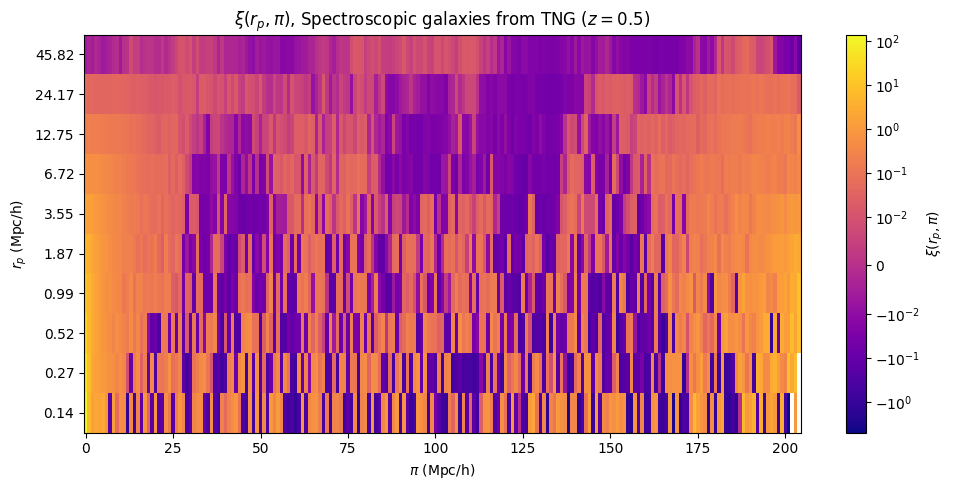

In [10]:
# plot this 2D xi(rp,pi)
norm = mpl.colors.SymLogNorm(1e-2)
fig, ax = plt.subplots(figsize=(10,5), tight_layout=True)
im = ax.imshow(xirppi, origin='lower', norm=norm, cmap='plasma', aspect='auto')
fig.colorbar(im, ax=ax, label=r'$\xi(r_p,\pi)$')
rp_labels = [f'{rp:.2f}' for rp in rp_avg]
ax.set_yticks(np.arange(nbins), labels=rp_labels)
ax.set_xlabel(r'$\pi$ (Mpc/h)')
ax.set_ylabel(r'$r_p$ (Mpc/h)')
ax.set_title(r'$\xi(r_p,\pi)$, Spectroscopic galaxies from TNG ($z=$'f'{sim.redshift})')

In [11]:
# sum over pi / r_parallel to get 1D wp(rp)
dpi = 1.  # Corrfunc uses unity resolution along LOS
wp1 = np.array([
    2.0 * dpi * np.nansum(xirp) for xirp in xirppi  # NANsum -> Corrfunc.convert_rp_pi_counts_to_wp uses np.sum
]) # ** why is the factor of two here???
wp1

array([367.09762833, 222.00217267, 160.75262864, 122.55476159,
        81.23279001,  47.48412691,  23.7557744 ,  14.6452745 ,
         5.26426858,  -1.88781831])

In [12]:
# sum over pi / r_parallel to get 1D wp(rp)
pi_edges = np.linspace(0, pimax, npibins+1)
piavg = 0.5 * (pi_edges[1:] + pi_edges[:-1])
wp2 = 2.0 * integrate.trapz(xirppi, x=piavg, axis=1)
wp2

array([         nan,          nan, 130.04945138, 102.66235407,
        74.13654922,  44.70577867,  22.70729724,  13.94711733,
         5.19566959,  -1.76332547])

In [13]:
# sum over pi / r_parallel to get 1D wp(rp)
pi_edges = np.linspace(0, pimax, npibins+1)
piavg = 0.5 * (pi_edges[1:] + pi_edges[:-1])
wp3 = 2.0 * integrate.simpson(xirppi, x=piavg, axis=1)
wp3

array([         nan,          nan, 126.18533706,  98.07548816,
        74.56374612,  44.51077157,  23.00485767,  13.6413833 ,
         5.32469254,  -1.67605221])

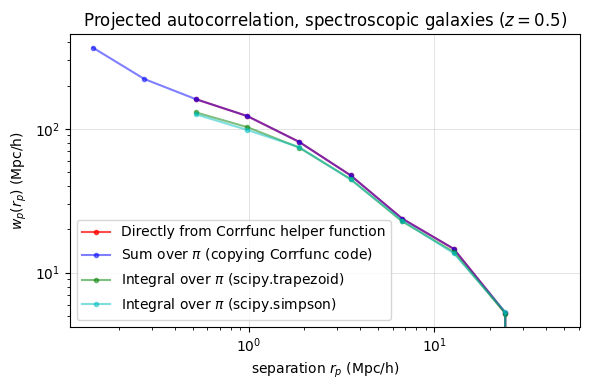

In [14]:
# compare the direct output from Corrfunc and my own sum over pi
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)

ax.plot(rp_avg, wp, marker='.', alpha=0.7, c='r', label='Directly from Corrfunc helper function')
ax.plot(rp_avg, wp1, marker='.', alpha=0.5, c='b', label=r'Sum over $\pi$ (copying Corrfunc code)')
ax.plot(rp_avg, wp2, marker='.', alpha=0.5, c='g', label=r'Integral over $\pi$ (scipy.trapezoid)')
ax.plot(rp_avg, wp3, marker='.', alpha=0.5, c='c', label=r'Integral over $\pi$ (scipy.simpson)')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$ (Mpc/h)')
ax.set_title(f"Projected autocorrelation, spectroscopic galaxies ("r"$z=$"f"{sim.redshift})")
ax.legend()

### compare to $w_p(r_p)$ computed from $\xi(r)$ $\rightarrow$ assumes isotropy

The projected correlation function is
$$
w_p(r_p) = \int_{-\infty}^\infty \xi(r_p,r_\pi)\,\mathrm{d}r_\pi
$$

(from van den Bosch's LSS slides: http://www.astro.yale.edu/vdbosch/astro610_lecture12.pdf)

Similarly, from Adam,
$$
w(r_p) = \int \mathrm{d}r_{||}\,\xi\left(\sqrt{r^2_{||} + r^2_p}\right)
$$

where $r\equiv\sqrt{r^2_{||} + r^2_p}$

In [15]:
# inputs: same bins as in alternative_limber_formula20240117.ipynb for a direct comparison
randmult = 3
rmin = 0.1
rmax = 100
nbins = 10
pimax = int(sim.boxsize.value) # max depth to integrate along LOS
nthreads = 10
periodic = False
nrepeats = 10  # how many times to repeat computation to help with noise / numerical errors ?

In [16]:
# compute the pair counts

# prep data
data_for_cf = corrfuncs.set_up_cf_data(gal_pos_spec, randmult=randmult, rmin=rmin, rmax=rmax, nbins=nbins,
                                  boxsize=sim.boxsize, logbins=True)
r_edges, r_avg, nd, _, boxsize, nr, rand_set, data_set, _ = data_for_cf.values()
assert np.allclose(boxsize, sim.boxsize.value)
assert np.all(rand_set >= 0) and np.all(rand_set <= boxsize)
assert np.all(data_set >= 0) and np.all(data_set <= boxsize)

# unpack
xd, yd, zd = data_set.T
xr, yr, zr = rand_set.T

xis = np.full((nrepeats,nbins), np.nan)

for j in range(nrepeats):

    dd_res = DD(1, nthreads, r_edges, xd, yd, zd, boxsize=boxsize, periodic=periodic, output_ravg=True)
    dr_res = DD(0, nthreads, r_edges, xd, yd, zd, X2=xr, Y2=yr, Z2=zr, boxsize=boxsize, periodic=periodic)
    rr_res = DD(1, nthreads, r_edges, xr, yr, zr, boxsize=boxsize, periodic=periodic)

    # turn pair counts into actual correlation function: Landy-Szalay estimator
    xis[j] = convert_3d_counts_to_cf(nd, nd, nr, nr, dd_res, dr_res, dr_res, rr_res)

xi = np.nanmean(xis, axis=0)  # get the mean across the runs

shifting data by L/2!


/work/08811/aew492/frontera/small-scale_cross-corrs/photxspec.py:229: RuntimeWarning: Mean of empty slice
  bias = np.nanmean(ratio[bias_range[0]:bias_range[1]])


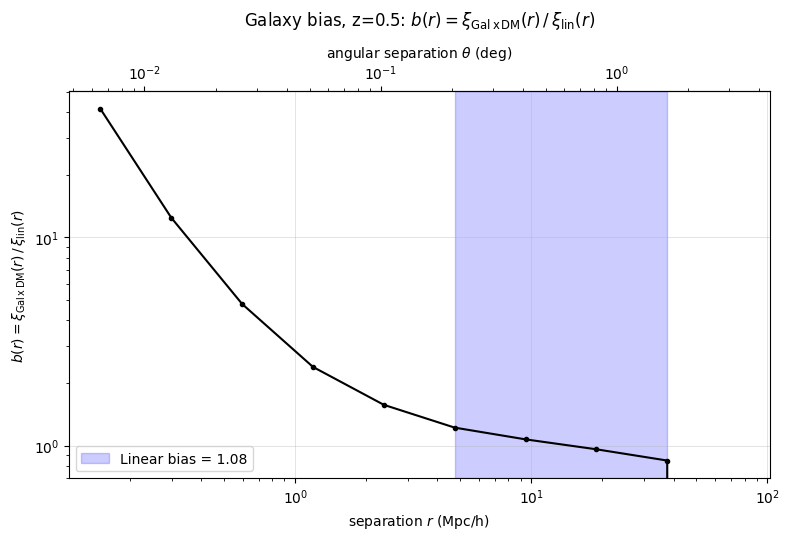

In [17]:
# compare to linear theory
xi_lin_dm = tools.linear_2pcf(sim.redshift, r_avg)

# get linear bias from spectroscopic sample
_, ratio = photxspec.get_linear_bias(gal_pos_spec, sim, r_edges=r_edges, return_ratio=True)

# range to compute linear bias
biasrange = (-5,-2) # indices from ravg
bias = np.mean(ratio[biasrange[0]:biasrange[1]])

fig, ax = plt.subplots(figsize=(8,5.5), tight_layout=True)
ax.plot(r_avg, ratio, 'k.-')
secax = ax.secondary_xaxis('top', functions=(r_comov_to_theta_, theta_to_r_comov_))
secax.set_xlabel(r'angular separation $\theta$ (deg)')
ax.axvspan(r_avg[-5], r_avg[-2], color='b', alpha=0.2, label=f'Linear bias = {bias:.2f}')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$b(r) = \xi_\mathrm{Gal\,x\,DM}(r)\,/\,\xi_\mathrm{lin}(r)$')
ax.set_title(f'Galaxy bias, z={sim.redshift}: 'r'$b(r) = \xi_\mathrm{Gal\,x\,DM}(r)\,/\,\xi_\mathrm{lin}(r)$', y=1.15)
ax.legend()

In [18]:
# galaxy c.f. is the matter c.f. times the bias squared
xi_lin = bias**2 * xi_lin_dm

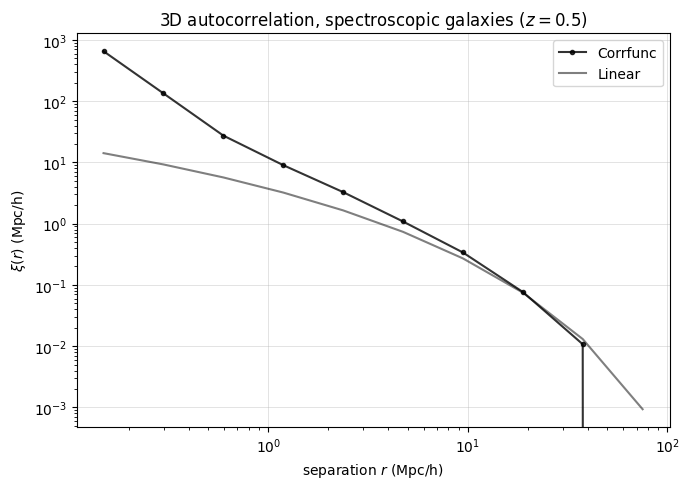

In [19]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

ax.plot(r_avg, xi, marker='.', alpha=0.8, c='k', label='Corrfunc' )
ax.plot(r_avg, xi_lin, 'k-', alpha=0.5, label='Linear')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$ (Mpc/h)')
ax.set_title(f"3D autocorrelation, spectroscopic galaxies ("r"$z=$"f"{sim.redshift})")
ax.legend()

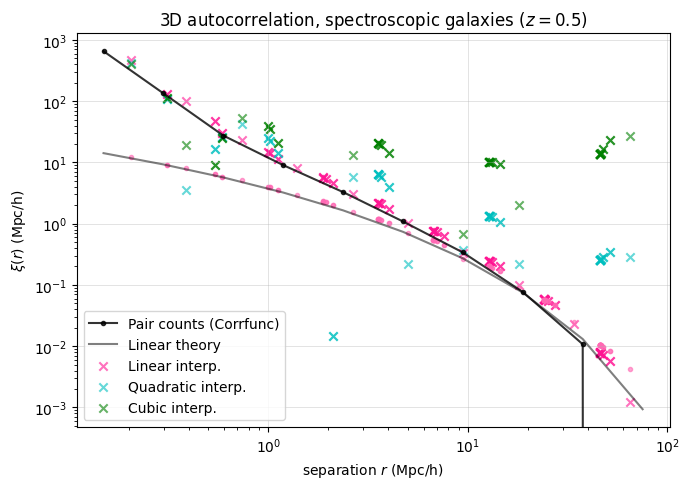

In [27]:
# use these as a lookup table to interpolate (rp,pi)
#  also plot to keep track of where the interpolated points land
rp = rp_avg
pi = rp_avg  # also use rp_avg

# interpolation functions
f1 = interpolate.interp1d(r_avg, xi, kind='linear')
f2 = interpolate.interp1d(r_avg, xi, kind='quadratic')
f3 = interpolate.interp1d(r_avg, xi, kind='cubic')
flin = interpolate.interp1d(r_avg, xi_lin, kind='linear')

# populate 2D array of separation r from each (r_p, pi) pair
r_arr = np.empty((len(rp), len(pi)))
for i, rp_ in enumerate(rp):
    for j, pi_ in enumerate(pi):
        r_arr[i,j] = np.sqrt(rp_**2 + pi_**2)
        if r_arr[i,j] > max(r_avg):
            print(f"r to evaluate ({r_arr[i,j]:.3f} Mpc/h) is greater than max r_avg ({max(r_avg):.3f})!")
            continue

# interpolate xi(r) on this r_arr grid
xi_arr = f1(r_arr)
xi_arr_quad = f2(r_arr)
xi_arr_cubic = f3(r_arr)

xi_lin_arr = flin(r_arr)
        
# plot
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

ax.plot(r_avg, xi, marker='.', alpha=0.8, c='k', label='Pair counts (Corrfunc)')
ax.plot(r_avg, xi_lin, 'k-', alpha=0.5, label='Linear theory')

ax.scatter(r_arr, xi_arr, c='deeppink', marker='x', alpha=0.6, label='Linear interp.')
ax.scatter(r_arr, xi_arr_quad, c='c', marker='x', alpha=0.6, label='Quadratic interp.')
ax.scatter(r_arr, xi_arr_cubic, c='g', marker='x', alpha=0.6, label='Cubic interp.')
ax.scatter(r_arr, xi_lin_arr, c='hotpink', marker='.', alpha=0.6)

ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$ (Mpc/h)')
ax.set_title(f"3D autocorrelation, spectroscopic galaxies ("r"$z=$"f"{sim.redshift})")
ax.legend()

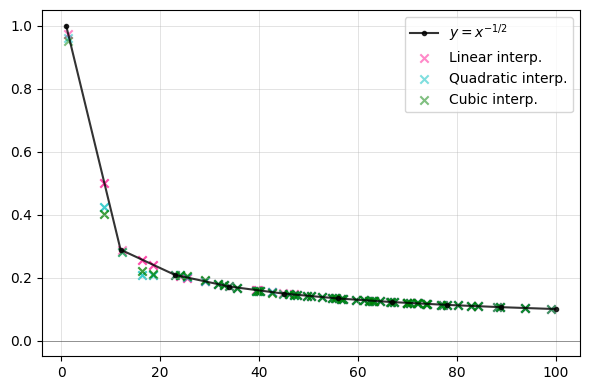

In [58]:
# try a different function??
x = np.linspace(1, 100, 10)
y = x ** (-1/2)

x1 = np.linspace(1, 70, 10)
x2 = x1.copy()
# populate 2D array of separation r from each (r_p, pi) pair
x_arr = np.empty((len(x1), len(x2)))
for i, x1_ in enumerate(x1):
    for j, x2_ in enumerate(x2):
        x_arr[i,j] = np.sqrt(x1_**2 + x2_**2)

# interpolation functions
f1_test = interpolate.interp1d(x, y, kind='linear')
f2_test = interpolate.interp1d(x, y, kind='quadratic')
f3_test = interpolate.interp1d(x, y, kind='cubic')

# interpolate y(x) on this x_arr grid
y_arr = f1_test(x_arr)
y_arr_quad = f2_test(x_arr)
y_arr_cubic = f3_test(x_arr)

fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(x, y, 'k.-', alpha=0.8, label=r'$y = x^{-1/2}$')
ax.scatter(x_arr, y_arr, c='deeppink', marker='x', alpha=0.5, label='Linear interp.')
ax.scatter(x_arr, y_arr_quad, c='c', marker='x', alpha=0.5, label='Quadratic interp.')
ax.scatter(x_arr, y_arr_cubic, c='g', marker='x', alpha=0.5, label='Cubic interp.')
ax.grid(alpha=0.5, lw=0.5)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.legend()

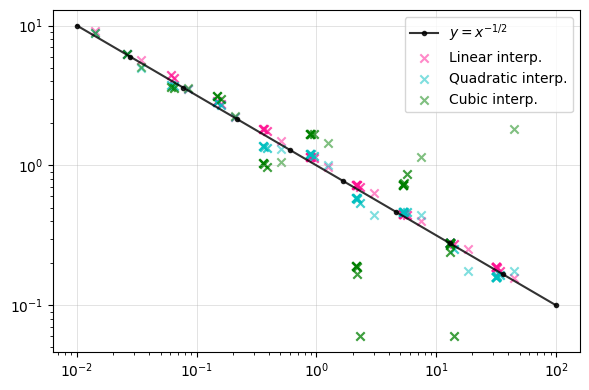

In [61]:
# log spaced??
x = np.logspace(-2, 2, 10)
y = x ** (-1/2)

x1 = np.logspace(-2, 1.5, 10)
x2 = x1.copy()
# populate 2D array of separation r from each (r_p, pi) pair
x_arr = np.empty((len(x1), len(x2)))
for i, x1_ in enumerate(x1):
    for j, x2_ in enumerate(x2):
        x_arr[i,j] = np.sqrt(x1_**2 + x2_**2)

# interpolation functions
f1_test = interpolate.interp1d(x, y, kind='linear')
f2_test = interpolate.interp1d(x, y, kind='quadratic')
f3_test = interpolate.interp1d(x, y, kind='cubic')

# interpolate y(x) on this x_arr grid
y_arr = f1_test(x_arr)
y_arr_quad = f2_test(x_arr)
y_arr_cubic = f3_test(x_arr)

fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(x, y, 'k.-', alpha=0.8, label=r'$y = x^{-1/2}$')
ax.scatter(x_arr, y_arr, c='deeppink', marker='x', alpha=0.5, label='Linear interp.')
ax.scatter(x_arr, y_arr_quad, c='c', marker='x', alpha=0.5, label='Quadratic interp.')
ax.scatter(x_arr, y_arr_cubic, c='g', marker='x', alpha=0.5, label='Cubic interp.')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.legend()

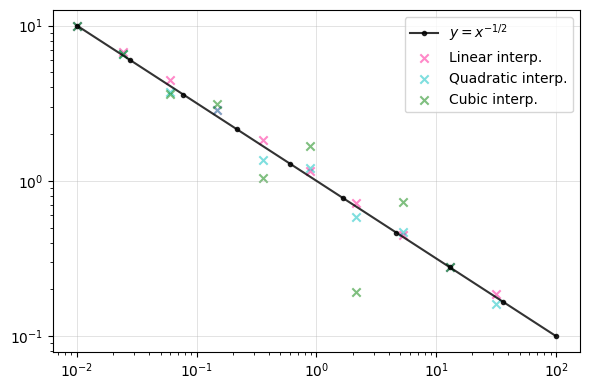

In [62]:
# try 1D interpolation instead of on a grid to make sure the grid isn't the problem
# log spaced??
x = np.logspace(-2, 2, 10)
y = x ** (-1/2)

x1 = np.logspace(-2, 1.5, 10)

# interpolation functions
f1_test = interpolate.interp1d(x, y, kind='linear')
f2_test = interpolate.interp1d(x, y, kind='quadratic')
f3_test = interpolate.interp1d(x, y, kind='cubic')

# interpolate y(x) on this x_arr grid
y_arr = f1_test(x1)
y_arr_quad = f2_test(x1)
y_arr_cubic = f3_test(x1)

fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(x, y, 'k.-', alpha=0.8, label=r'$y = x^{-1/2}$')
ax.scatter(x1, y_arr, c='deeppink', marker='x', alpha=0.5, label='Linear interp.')
ax.scatter(x1, y_arr_quad, c='c', marker='x', alpha=0.5, label='Quadratic interp.')
ax.scatter(x1, y_arr_cubic, c='g', marker='x', alpha=0.5, label='Cubic interp.')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.legend()

Text(0.5, 1.0, '$\\xi(r_p,\\pi)$, Spectroscopic galaxies from TNG ($z=$0.5), from isotropic $\\xi(r)$')

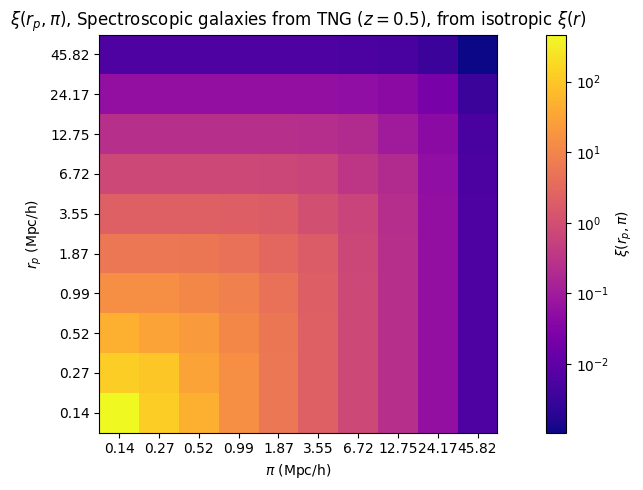

In [28]:
# plot this 2D xi(rp,pi)
norm = mpl.colors.SymLogNorm(1e-2)
fig, ax = plt.subplots(figsize=(10,5), tight_layout=True)
im = ax.imshow(xi_arr, origin='lower', norm=norm, cmap='plasma')
fig.colorbar(im, ax=ax, label=r'$\xi(r_p,\pi)$')
pi_labels = [f'{x:.2f}' for x in pi]
ax.set_xticks(np.arange(nbins), labels=pi_labels)
rp_labels = [f'{x:.2f}' for x in rp]
ax.set_yticks(np.arange(nbins), labels=rp_labels)
ax.set_xlabel(r'$\pi$ (Mpc/h)')
ax.set_ylabel(r'$r_p$ (Mpc/h)')
ax.set_title(r'$\xi(r_p,\pi)$, Spectroscopic galaxies from TNG ($z=$'f'{sim.redshift}), from isotropic 'r'$\xi(r)$')

In [31]:
# sum over pi / r_parallel to get 1D wp(rp)
wp_isotropic = 2.0 * integrate.trapz(xi_arr, x=pi, axis=0)
wp_lin_isotropic = 2.0 * integrate.trapz(xi_lin_arr, x=pi, axis=0)

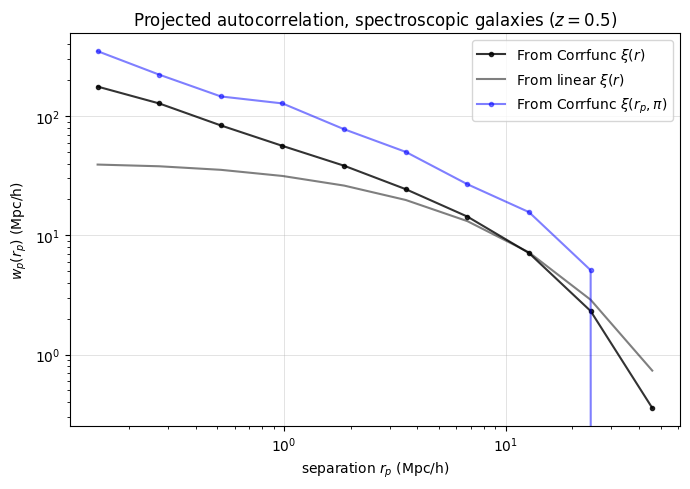

In [33]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

ax.plot(rp, wp_isotropic, marker='.', alpha=0.8, c='k', label=r'From Corrfunc $\xi(r)$')
ax.plot(rp, wp_lin_isotropic, alpha=0.5, c='k', label=r'From linear $\xi(r)$')
ax.plot(rp_avg, wp1, marker='.', alpha=0.5, c='b', label=r'From Corrfunc $\xi(r_p,\pi)$')
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$ (Mpc/h)')
ax.set_title(f"Projected autocorrelation, spectroscopic galaxies ("r"$z=$"f"{sim.redshift})")
ax.legend()

Text(0.5, 1.0, 'Ratio between $w_p$ from $\\xi(r_p,\\pi)$ and $w_p$ from $\\xi(r)$')

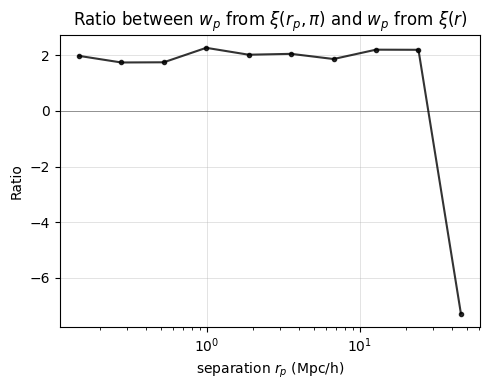

In [39]:
# plot the ratio to understand a bit better
ratio = wp1 / wp_isotropic

fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)

ax.plot(rp, ratio, marker='.', alpha=0.8, c='k')
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.semilogx()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'Ratio')
ax.set_title(r"Ratio between $w_p$ from $\xi(r_p,\pi)$ and $w_p$ from $\xi(r)$")